In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from uncertainties import ufloat, unumpy

In [2]:
def gauss(x, A, mu, sig):
    return A*np.exp(-((x-mu)/sig)**2)

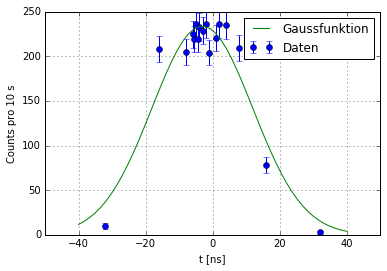

[ 233.6853484    -3.06766506   21.31869156] [[ 46.35323398  -0.20108198  -4.67218571]
 [ -0.20108198   1.30841834  -0.36246024]
 [ -4.67218571  -0.36246024   3.39657851]]


In [10]:
df = pd.read_csv('../daten/zeit.dat', header=0, names=['t','counts','messzeit'], skipinitialspace=True)
df.fillna(10, inplace=True)
df['count10'] = df.counts / df.messzeit*10


popt1, pcov1 = curve_fit(gauss, df.t.values, df.count10.values)

x = np.linspace(-40, 40, 50)
y = gauss(x, popt1[0], popt1[1], popt1[2])

#print(popt,pcov)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x=df['t'].values, y=df['count10'].values, yerr=np.sqrt(df.count10.values), label='Daten', linestyle='None', marker='o')
ax.plot(x,y, label='Gaussfunktion')
ax.grid()
ax.set_xlim((-50,50))
ax.set_ylim((0,250))
ax.set_xlabel('t [ns]')
ax.set_ylabel('Counts pro 10 s')
ax.legend(loc='upper right')
plt.savefig('../tex/Bilder/koinzidenz.pdf')
plt.show()
print(popt1,pcov1)
#df.to_latex('Koinzidenz.dat', column_format='lcc', index=False, float_format=lambda x : str(round(x,1)), columns=['t', 'messzeit','counts', 'count10'])

In [40]:
df2 = pd.read_csv('../daten/kalibration.Spe', comment='#', skipinitialspace=True, header=None, names=['count'])
df2 = df2[(df2['count'].values != 0)]
df2['channel'] = df2.index.values

# meld channels that lie next to each other
channelList = list()
countList = list()
errList = list()
tempChannelList = list()
tempCountList = list()

def mergeList(l1, l2):
    totCount = np.sum(l2)
    meanChan = np.average(l1, weights=l2)
    std = np.sqrt(np.average((l1-meanChan)**2, weights=l2))
    return meanChan, totCount, std

for i in df2.iterrows():
    # wenn Liste noch leer, erzeuge ersten Eintrag
    if not tempChannelList:
        tempChannelList.append(i[0])
        tempCountList.append(i[1]['count'])
    else:
        # wenn Liste nicht leer und vorheriger Channel ist in der Liste
        if i[0]-1 in tempChannelList:
            tempChannelList.append(i[0])
            tempCountList.append(i[1]['count'])
        else:
            # Aktueller wert gehört zu neuem Channel -> merge alle alten und erzeuge neue leere liste
            chann, count, err = mergeList(tempChannelList, tempCountList)
            tempChannelList = list()
            tempCountList = list()
            channelList.append(chann)
            countList.append(count)
            errList.append(err)
            tempChannelList.append(i[0])
            tempCountList.append(i[1]['count'])
chann, count, err = mergeList(tempChannelList, tempCountList)
channelList.append(chann)
countList.append(count)
errList.append(err)
df3 = pd.DataFrame({'counts' : countList, 'channel' : channelList, 'error':errList, 'deltaT' : [1,2,3,4,5,6,7,8,9]})

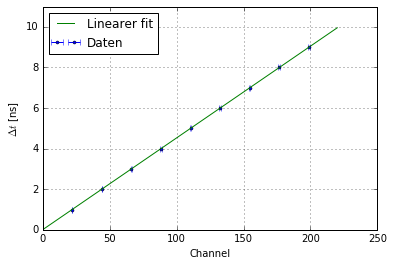

0    0.000000
1    0.022704
2    0.447362
3    0.485117
4    0.496660
5    0.499916
6    0.577806
7    0.778843
8    0.840156
Name: error, dtype: float64


In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x=df3['channel'], y=df3['deltaT'], xerr=df3['error'], label='Daten', ms=3, marker='o', linestyle='None')
ax.grid()
ax.set_xlabel('Channel')
ax.set_ylabel(r'$\Delta t$ [ns]')

def lin(x, m, b):
    return m*x+b

popt2, pcov2 = curve_fit(lin, df3.channel.values, df3.deltaT.values, sigma=1/df3.error.values)
x = np.linspace(0, 220, 5)
y = lin(x, popt2[0], popt2[1])
ax.plot(x,y, label='Linearer fit')
ax.legend(loc='best')
ax.set_xlim((0,250))
ax.set_ylim((0,11))

plt.savefig('../tex/Bilder/linFit.pdf')
plt.show()
print(df3.error)
#df3.to_latex('LinFit.dat', column_format='lcc', index=False, float_format=lambda x : str(round(x,2)))

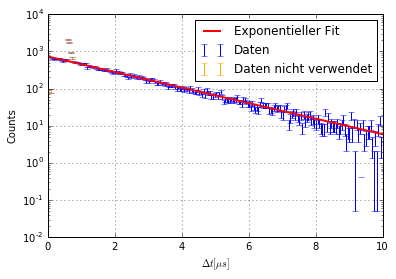

In [91]:
def exp(x, A, b):
    return A*np.exp(x/b)

df4 = pd.read_csv('../daten/daten.Spe', comment='#', skipinitialspace=True, header=None, names=['count'])
df4['count'] = df4['count'] - 7.9 #Background
df4['channel'] = df4.index.values
df4['deltaT'] = lin(df4.channel, popt2[0], popt2[1])
df4.query('count > 0', inplace=True)

df4Fit = df4.query('(channel< 13 | channel>16) & channel > 2')
df4NoFit = df4.query('13 <= channel <=16 | channel <3')
popt3, pcov3 = curve_fit(exp, df4Fit.deltaT, df4Fit['count'], p0=[500,-0.2])
x = np.linspace(0, 22, 100)
y = exp(x, popt3[0], popt3[1])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x=df4['deltaT'], y=df4['count'], yerr=np.sqrt(df4['count'].values), label='Daten', linestyle='None')
ax.errorbar(x=df4NoFit['deltaT'], y=df4NoFit['count'], yerr=np.sqrt(df4NoFit['count'].values), label='Daten nicht verwendet', color='orange', linestyle='None')
ax.plot(x,y, c='red',lw=2, label='Exponentieller Fit')
ax.grid()
ax.legend()
ax.set_ylabel('Counts')
ax.set_xlabel(r'$\Delta t [\mu s]$')
ax.set_xlim((0,10))
ax.semilogy()
plt.savefig('../tex/Bilder/lebensdauer.pdf')
plt.show()